In [7]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import operator
from tqdm import tqdm
import time
class KNN_Classifier:
    def __init__(self, K=1):
        self.n_neighbor = K
    
    def fit(self, X, Y):
        self.train_data = X
        self.train_labels = Y
    
    def get_distance(self, train_X, test_X):
        total = 0
        for i in range(len(train_X)):
            total = total + np.square(test_X[i]-train_X[i])
        return np.sqrt(total)
    
    def predict_labels(self, test_X):
        test_labels=[]
        for test_d in test_X:
            pred_label = self.predict_label(test_d)
            test_labels.append(pred_label)
        return test_labels
    
    def predict_label(self, test_x):
        distance_map = {}
        for i in range(len(self.train_data)):
            dist = self.get_distance(test_x, self.train_data[i])
            distance_map[i]=dist
            
        sorted_dist = sorted(distance_map.items(), key = operator.itemgetter(1))

        neighbors_list = []
        for i in range(self.n_neighbor):
            neighbors_list.append(sorted_dist[i][0])
        

        majority_vote = {}
        for i in range(len(neighbors_list)):
            label = self.train_labels[neighbors_list[i]]

            if label in majority_vote:
                majority_vote[label]+=1
            else:
                majority_vote[label]=1
        

        sorted_vote = sorted(majority_vote.items(), key=operator.itemgetter(1), reverse=True)
        pred_label = sorted_vote[0][0]
        
        return pred_label
    
def accuracy_score(actual_labels, pred_labels):
    correct = 0
    for i in range(len(actual_labels)):
        if actual_labels[i] == pred_labels[i]:
            correct += 1
    accuracy = correct/len(pred_labels)
    return accuracy

In [8]:
def cross_validation(model, data, target, k=10):
    data_size = data.shape[0]
    fold_size = data_size // k
    accuracies = []

    for i in range(k):
        start = i * fold_size
        if i < k-1:
            end = (i + 1) * fold_size
        else:
            end = data_size
        
        #select train data
        train_data = np.concatenate([data[:start], data[end:]])
        train_target = np.concatenate([target[:start], target[end:]])
        
        #select test data
        test_data = data[start:end]
        test_target = target[start:end]

        model.fit(train_data, train_target)
        predictions = model.predict_labels(test_data)
        
        accuracy = accuracy_score(test_target, predictions)
        accuracies.append(accuracy)
    # get avg accuracy of k accuracies
    accuracy = np.mean(accuracies)
    return accuracy


def get_data_for_selected_features(df, selected_features):
    X = df[selected_features].to_numpy()
    Y = df['label'].to_numpy()
    return X, Y

def forward_selection(df, accuracy_dict):
    features = get_features_list(df)
    selected_features = []
    K = 3
    all_best_accuracy = 0.0
    all_best_features = []
    num_features = []  # list to keep track of the number of features
    accuracies = []  # list to keep track of the accuracies
    print("Starting Forward Selection Search")
    prev_acc = 0.0
    for i in tqdm(range(len(features))):
        print("Level ", i+1, " using ", i+1, " features: ")
        best_accuracy = 0.0 
        best_feature = None
        for feature in features:
            if feature not in selected_features:
                current_features = selected_features + [feature]
                current_features = sorted(current_features)
                key = "_".join(map(str, current_features))
                if key not in accuracy_dict:
                    X, Y = get_data_for_selected_features(df, current_features)

                    model = KNN_Classifier(K=K)
                    accuracy = cross_validation(model, X, Y)
                    accuracy_dict[key] = accuracy
                else:
                    accuracy = accuracy_dict[key]
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_feature = feature

                print("\tAccuracy: ", accuracy, " after adding ", feature)

        if best_feature is not None:  # Only add feature if one improved the model
            selected_features.append(best_feature)
            features.remove(best_feature)  # Remove the selected feature from the original list
            num_features.append(len(selected_features))  # append the current number of features
            accuracies.append(best_accuracy)  # append the current best accuracy

        if best_accuracy > all_best_accuracy:
            all_best_accuracy = best_accuracy
            all_best_features = selected_features.copy()
            print("Best feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Feature list: ", selected_features)
        else:
            print("Attention!! Accuracy has not improved by adding this feature!")
            print("Best feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Feature list: ", selected_features)
        print()

    all_best_features = sorted(all_best_features)
    print(f'Selected features: {all_best_features}')
    print("Best accuracy: ", all_best_accuracy)
    
    return num_features, accuracies, all_best_features, accuracy_dict
    
def backward_selection(df, accuracy_dict):
    features = get_features_list(df)
    selected_features = features  # start with all features
    K = 3
    all_best_accuracy = 0.0
    all_best_features = selected_features.copy()

    # First evaluate the model with all features
    X, Y = get_data_for_selected_features(df, selected_features)

    model = KNN_Classifier(K=K)
    accuracy = cross_validation(model, X, Y)
    key = "_".join(map(str, selected_features))
    accuracy_dict[key] = accuracy
    all_best_accuracy = accuracy
    print("Initial accuracy with all features: ", all_best_accuracy)
    
    num_features = []  # list to keep track of the number of features
    accuracies = []  # list to keep track of the accuracies
    print("Starting Backward Selection Search")
    i = len(features)
    while i > 0:
        print("Level ", i, " using ", i, " features: ")
        best_accuracy = 0.0 
        best_feature = None
        for feature in selected_features:
            current_features = selected_features.copy()
            current_features.remove(feature)
            current_features = sorted(current_features)
            key = "_".join(map(str, current_features))
            if key not in accuracy_dict:
                X, Y = get_data_for_selected_features(df, current_features)

                model = KNN_Classifier(K=K)
                accuracy = cross_validation(model, X, Y)
                accuracy_dict[key] = accuracy
            else:
                accuracy = accuracy_dict[key]

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
            
            print("\tAccuracy: ", accuracy, " after removing ", feature)

        if best_feature is not None:  # Only remove feature if it improved the model
            selected_features.remove(best_feature)  # Remove the selected feature from the original list
            num_features.append(len(selected_features))  # append the current number of features
            accuracies.append(best_accuracy)  # append the current best accuracy
            i -= 1

        if best_accuracy >= all_best_accuracy:
            all_best_accuracy = best_accuracy
            all_best_features = selected_features.copy()
            print("Removed feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Current feature list: ", selected_features)
        else:
            print("Attention!! Accuracy has not improved by removing this feature!")
            print("Removed feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Current feature list: ", selected_features)
        print()

    all_best_features = sorted(all_best_features)
    print(f'Selected features: {all_best_features}')
    print("Best accuracy: ", all_best_accuracy)
    
    return num_features, accuracies, all_best_features, accuracy_dict



In [9]:
def load_diabetes_dataset(filename = 'diabetes.csv'):
    data = pd.read_csv(filename)
    
    # Save original column names
    original_columns = data.columns.tolist()

    # Prepare new column names
    new_cols = ['label' if col=='label' else i+1 for i, col in enumerate(data.columns)]

    # Rename columns
    data.columns = new_cols

    # Create a dictionary mapping new column names to old ones
    col_name_mapping = {new: old for new, old in zip(new_cols, original_columns)}

    return data, col_name_mapping

def min_max_scaler(data):
    min_val = data.min()
    max_val = data.max()

    data_normalized = (data - min_val) / (max_val - min_val)

    return data_normalized

def shuffle_normalize(df):
    df = df.sample(frac=1.0, random_state=42)
    
    normalized_df = df.copy()
    features = df.columns.drop('label')
    normalized_df[features] = min_max_scaler(df[features])

    return normalized_df

def get_features_list(data):
    columns = list(data.columns)
    features = []
    for val in columns:
        if val != 'label':
            features.append(val)
    return features

def plot_feature_count_vs_accuracies(num_features, accuracies, title):
    plt.plot(num_features, accuracies)
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

In [10]:
def load_dataset(file_name="CS170_small_Data__18.txt"):
    if file_name == "diabetes.csv":
        return load_diabetes_dataset()
    # Determine the number of columns in your data file if not known
    with open(file_name, 'r') as f:
        line = f.readline()
        num_cols = len(line.split())

    # Create column names
    col_names = ['label'] + [i+1 for i in range(num_cols - 1)]

    # Load the data
    data = pd.read_csv(file_name, names=col_names, delim_whitespace=True)
    
    if file_name == "CS170_XXXlarge_Data__12.txt":
        print("Sampling 50% of dataset!!")
        data = data.sample(frac=0.5, random_state=42).reset_index(drop=True)

    return data, col_names


In [11]:
def apply_feature_selection(feature_selection, file_name, accuracy_cache):
    data, _ = load_dataset(file_name)
    data = shuffle_normalize(data)
    print(data.shape)
    
    # test_frac=0.25
    # train_df, test_df = train_test_split(data, test_frac)


    if feature_selection == '1':
        num_features1, accuracies1, \
        all_best_features1, accuracy_cache = forward_selection(data,accuracy_cache)
        title = 'Forward Selection: Accuracy vs Number of Features'
        plot_feature_count_vs_accuracies(num_features1, accuracies1, title)

    elif feature_selection == '2':
        num_features1, accuracies1, \
        all_best_features1, accuracy_cache = backward_selection(data,accuracy_cache)
        title = 'Backward Selection: Accuracy vs Number of Features'
        plot_feature_count_vs_accuracies(num_features1, accuracies1, title)
    return num_features1, accuracies1, all_best_features1, accuracy_cache

Welcome to Feature Selection Algorithm!


Select the dataset you want to test
	 1 for Small Dataset 
	 2 for Large Dataset 
	 3 for XXX_Large Dataset 
	 4 for Diabetes Dataset 4
Select feature selection option 
	 1 for Forward Feature Selection 
	 2 for Backward Feature Selection 1


(768, 9)
Starting Forward Selection Search


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Level  1  using  1  features: 
	Accuracy:  0.5721804511278197  after adding  1
	Accuracy:  0.6748120300751881  after adding  2
	Accuracy:  0.5973057644110276  after adding  3
	Accuracy:  0.581077694235589  after adding  4
	Accuracy:  0.6216791979949876  after adding  5
	Accuracy:  0.6379699248120301  after adding  6
	Accuracy:  0.5650375939849624  after adding  7


 12%|█████▋                                       | 1/8 [00:38<04:28, 38.29s/it]

	Accuracy:  0.6216791979949875  after adding  8
Best feature:  2  with accuracy:  0.6748120300751881
Feature list:  [2]

Level  2  using  2  features: 
	Accuracy:  0.7027568922305764  after adding  1
	Accuracy:  0.693922305764411  after adding  3
	Accuracy:  0.6739348370927318  after adding  4
	Accuracy:  0.6760025062656643  after adding  5
	Accuracy:  0.699436090225564  after adding  6
	Accuracy:  0.731328320802005  after adding  7


 25%|███████████▎                                 | 2/8 [01:27<04:27, 44.50s/it]

	Accuracy:  0.7102130325814537  after adding  8
Best feature:  7  with accuracy:  0.731328320802005
Feature list:  [2, 7]

Level  3  using  3  features: 
	Accuracy:  0.7109022556390978  after adding  1
	Accuracy:  0.7015664160401003  after adding  3
	Accuracy:  0.7102756892230577  after adding  4
	Accuracy:  0.7114661654135339  after adding  5
	Accuracy:  0.7211779448621554  after adding  6


 38%|████████████████▉                            | 3/8 [02:19<04:01, 48.20s/it]

	Accuracy:  0.718671679197995  after adding  8
Attention!! Accuracy has not improved by adding this feature!
Best feature:  6  with accuracy:  0.7211779448621554
Feature list:  [2, 7, 6]

Level  4  using  4  features: 
	Accuracy:  0.7223684210526315  after adding  1
	Accuracy:  0.7025062656641603  after adding  3
	Accuracy:  0.7117167919799499  after adding  4
	Accuracy:  0.7273809523809524  after adding  5


 50%|██████████████████████▌                      | 4/8 [03:12<03:20, 50.05s/it]

	Accuracy:  0.7357769423558898  after adding  8
Best feature:  8  with accuracy:  0.7357769423558898
Feature list:  [2, 7, 6, 8]

Level  5  using  5  features: 
	Accuracy:  0.7363408521303259  after adding  1
	Accuracy:  0.7347117794486216  after adding  3
	Accuracy:  0.731829573934837  after adding  4


 62%|████████████████████████████▏                | 5/8 [04:05<02:32, 50.96s/it]

	Accuracy:  0.7451127819548873  after adding  5
Best feature:  5  with accuracy:  0.7451127819548873
Feature list:  [2, 7, 6, 8, 5]

Level  6  using  6  features: 
	Accuracy:  0.7342105263157894  after adding  1
	Accuracy:  0.7238095238095238  after adding  3


 75%|█████████████████████████████████▊           | 6/8 [04:55<01:41, 50.73s/it]

	Accuracy:  0.750125313283208  after adding  4
Best feature:  4  with accuracy:  0.750125313283208
Feature list:  [2, 7, 6, 8, 5, 4]

Level  7  using  7  features: 
	Accuracy:  0.7326441102756893  after adding  1


 88%|███████████████████████████████████████▍     | 7/8 [05:31<00:45, 45.80s/it]

	Accuracy:  0.7288220551378447  after adding  3
Attention!! Accuracy has not improved by adding this feature!
Best feature:  1  with accuracy:  0.7326441102756893
Feature list:  [2, 7, 6, 8, 5, 4, 1]

Level  8  using  8  features: 


100%|█████████████████████████████████████████████| 8/8 [05:50<00:00, 43.85s/it]

	Accuracy:  0.7315789473684211  after adding  3
Attention!! Accuracy has not improved by adding this feature!
Best feature:  3  with accuracy:  0.7315789473684211
Feature list:  [2, 7, 6, 8, 5, 4, 1, 3]

Selected features: [2, 4, 5, 6, 7, 8]
Best accuracy:  0.750125313283208


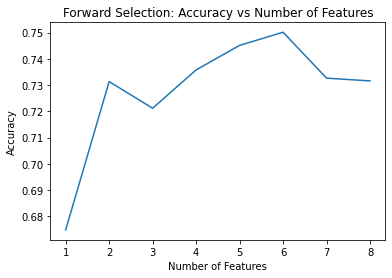

Total time taken: 351.12572479248047 seconds
Welcome to Feature Selection Algorithm!


Select the dataset you want to test
	 1 for Small Dataset 
	 2 for Large Dataset 
	 3 for XXX_Large Dataset 
	 4 for Diabetes Dataset 1
Select feature selection option 
	 1 for Forward Feature Selection 
	 2 for Backward Feature Selection 1


(1000, 11)
Starting Forward Selection Search


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Level  1  using  1  features: 
	Accuracy:  0.7190000000000001  after adding  1
	Accuracy:  0.7229999999999999  after adding  2
	Accuracy:  0.7219999999999999  after adding  3
	Accuracy:  0.836  after adding  4
	Accuracy:  0.7289999999999999  after adding  5
	Accuracy:  0.731  after adding  6
	Accuracy:  0.7079999999999999  after adding  7
	Accuracy:  0.7190000000000001  after adding  8
	Accuracy:  0.724  after adding  9


 10%|████▍                                       | 1/10 [01:31<13:42, 91.38s/it]

	Accuracy:  0.7470000000000001  after adding  10
Best feature:  4  with accuracy:  0.836
Feature list:  [4]

Level  2  using  2  features: 
	Accuracy:  0.8150000000000001  after adding  1
	Accuracy:  0.8079999999999998  after adding  2
	Accuracy:  0.8110000000000002  after adding  3
	Accuracy:  0.8099999999999999  after adding  5
	Accuracy:  0.834  after adding  6
	Accuracy:  0.8219999999999998  after adding  7


In [ ]:
if __name__ == "__main__":
    small_data_accuracy_cache = {}
    large_data_accuracy_cache = {}
    xlarge_data_accuracy_cache = {} #get_accuracy_dict()
    diabetes_data_accuracy_cache = {}
    while(True):
        print("Welcome to Feature Selection Algorithm!")
        data_selection = input("Select the dataset you want to test\n" + \
                                "\t 1 for Small Dataset \n" + \
                                "\t 2 for Large Dataset \n" + \
                                "\t 3 for XXX_Large Dataset \n" + \
                                "\t 4 for Diabetes Dataset")
        
        feature_selection = input("Select feature selection option \n" + \
                                 "\t 1 for Forward Feature Selection \n" + \
                                 "\t 2 for Backward Feature Selection")
        
        if data_selection == '1':
            start_time = time.time()
            file_name="data_sets/CS170_small_Data__18.txt"
            #data = load_dataset(file_name)
            num_features1, accuracies1, all_best_features1, large_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, large_data_accuracy_cache)
            end_time = time.time()
            print(f"Total time taken: {end_time - start_time} seconds")
        
        elif data_selection == '2':
            start_time = time.time()
            file_name="data_sets/CS170_large_Data__31.txt"
            num_features1, accuracies1, all_best_features1, large_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, large_data_accuracy_cache)
            end_time = time.time()
            print(f"Total time taken: {end_time - start_time} seconds")
        
        elif data_selection == '3':
            start_time = time.time()
            print(len(xlarge_data_accuracy_cache))
            file_name="data_sets/CS170_XXXlarge_Data__12.txt"
            num_features1, accuracies1, all_best_features1, xlarge_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, xlarge_data_accuracy_cache)
            end_time = time.time()
            print(f"Total time taken: {end_time - start_time} seconds")
        
        elif data_selection == '4':
            start_time = time.time()
            file_name = 'diabetes.csv'
            num_features1, accuracies1, all_best_features1, diabetes_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, diabetes_data_accuracy_cache)
            end_time = time.time()
            print(f"Total time taken: {end_time - start_time} seconds")